<a href="https://colab.research.google.com/github/GenoKiller777/PythonVarios/blob/main/Regresion_Multilineal_DarwinJoanPerezAvendano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving millas-por-galon.csv to millas-por-galon.csv
User uploaded file "millas-por-galon.csv" with length 21366 bytes


## Invocación de paquetes

In [2]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as sfm
import statsmodels.tools.eval_measures as metrics

### Carga del set de datos

In [3]:
cars = pd.read_csv('millas-por-galon.csv')

In [4]:
#Las primeras 2 filas son parte de un encabezado, por lo cual se eliminaran
cars.head(3)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car name
0,discrete,continuous,continuous,continuous,continuous,discrete,discrete,continuous,string
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu


### Eliminación de las 2 primeras filas
No son del soporte de los datos, son del encabezado.

In [5]:
cars.drop(cars.head(2).index,inplace=True)
cars.reset_index(inplace = True)
cars = cars.drop(columns=['index'])

In [6]:
cars.head(3)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car name
0,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu
1,8,350.0,165.0,3693.0,11.5,70,1,15.0,buick skylark 320
2,8,318.0,150.0,3436.0,11.0,70,1,18.0,plymouth satellite


### Revisión de los metadatos

In [7]:
#Forma del soporte
cars.shape

(398, 9)

In [8]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cylinders     398 non-null    object
 1   displacement  398 non-null    object
 2   horsepower    392 non-null    object
 3   weight        398 non-null    object
 4   acceleration  398 non-null    object
 5   model year    398 non-null    object
 6   origin        398 non-null    object
 7   mpg           398 non-null    object
 8   car name      398 non-null    object
dtypes: object(9)
memory usage: 28.1+ KB


In [9]:
cars.dtypes

cylinders       object
displacement    object
horsepower      object
weight          object
acceleration    object
model year      object
origin          object
mpg             object
car name        object
dtype: object

## Tratamiento de valores nulos

### Conteo de valores Nulos

In [10]:
#Hay 6 valores nulos en la columna 'horsepower

cars.isna().sum()

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
mpg             0
car name        0
dtype: int64

### Verificación de filas que tienen los valores NaN

In [11]:
invalid_rows = [index for index, row in cars.iterrows() if row.isnull().any()]
print(invalid_rows)
print()
print("Verificación de la fila")
cars.iloc[336]

[32, 126, 330, 336, 354, 374]

Verificación de la fila


cylinders                        4
displacement                 140.0
horsepower                     NaN
weight                      2905.0
acceleration                  14.3
model year                      80
origin                           1
mpg                           23.6
car name        ford mustang cobra
Name: 336, dtype: object

### Imputación de valores NaN, usando KNNImputer

In [12]:
from sklearn.impute import KNNImputer

# Construimos el modelo
imputer = KNNImputer(n_neighbors=10, weights="uniform")
imputer.fit(cars[['horsepower']])

KNNImputer(n_neighbors=10)

In [13]:
cars['horsepower'] = imputer.transform(cars[['horsepower']]).ravel()

In [14]:
cars.iloc[354]

cylinders                 4
displacement          100.0
horsepower       104.469388
weight               2320.0
acceleration           15.8
model year               81
origin                    2
mpg                    34.5
car name        renault 18i
Name: 354, dtype: object

### Verificación del relleno de valores NaN

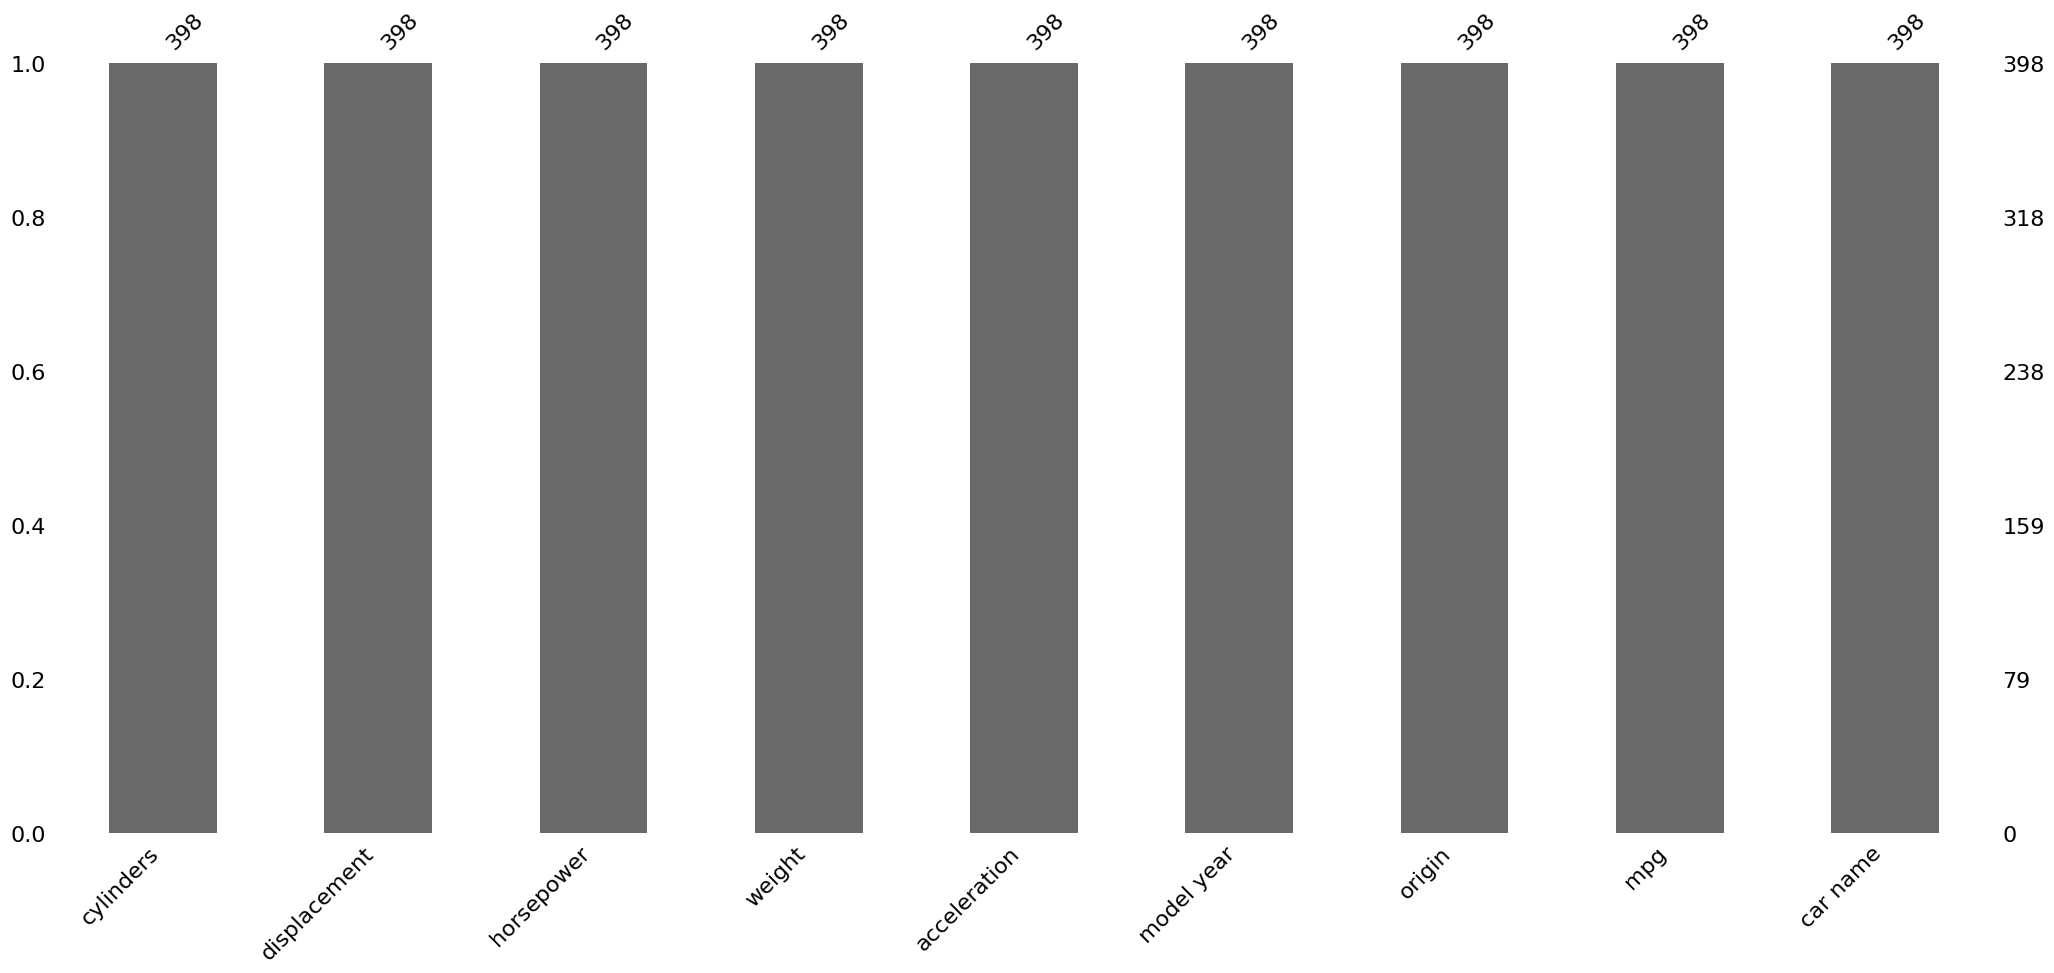

In [15]:
#La data esta completa.

msno.bar(cars)
plt.show()

## Analísis exploratorio de datos

### Analísis inicial de datos **IDA**

#### Mapeo de valores

In [16]:
cars['cylinders'] = cars['cylinders'].astype('category')
cars['displacement'] = pd.to_numeric(cars['displacement'])
cars['horsepower'] = pd.to_numeric(cars['horsepower'])
cars['acceleration'] = pd.to_numeric(cars['acceleration'])
cars['weight'] = pd.to_numeric(cars['weight'])
cars['model year'] = cars['model year'].astype('category')
cars['origin'] = cars['origin'].astype('category')
cars['mpg'] = pd.to_numeric(cars['mpg'])
cars['car name'] = cars['car name'].astype('category')

#### Análisis de Outliers

In [17]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.469388,38.199187,46.0,76.000,95.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


##### Feature: **'displacement'**

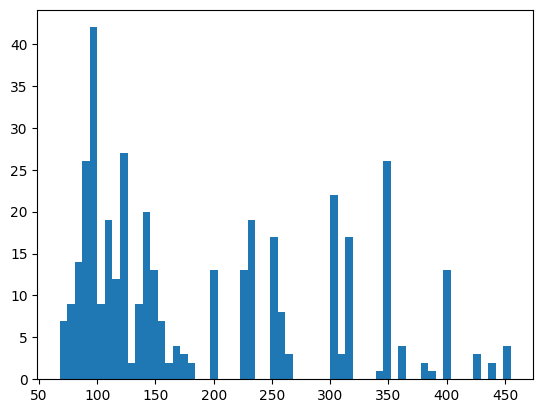

In [18]:
# Histograma
plt.hist(cars['displacement'],bins = 60)

plt.show()

In [19]:
fig = px.box(cars, y = 'displacement')
fig.show()

In [20]:
# Rango intercuartil
Q1_disp = cars['displacement'].quantile(q=0.25)
Q3_disp = cars['displacement'].quantile(q=0.75)

IQR_disp = Q3_disp - Q1_disp
print(IQR_disp," <- Rango Intercuartil ||| Mediana -> " ,cars['displacement'].median())

157.75  <- Rango Intercuartil ||| Mediana ->  148.5


In [21]:
min_limit_disp = Q1_disp - 1.5 * IQR_disp # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_disp = Q3_disp + 1.5 * IQR_disp

print(min_limit_disp, max_limit_disp)

-132.375 498.625


##### Feature: **'horsepower'**

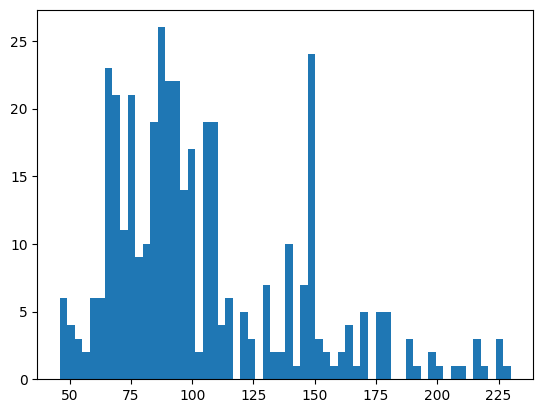

In [22]:
# Histograma
plt.hist(cars['horsepower'],bins = 60)

plt.show()

In [23]:
fig = px.box(cars, y = 'horsepower')
fig.show()

In [24]:
# Rango intercuartil
Q1_hp = cars['horsepower'].quantile(q=0.25)
Q3_hp = cars['horsepower'].quantile(q=0.75)

IQR_hp = Q3_hp - Q1_hp
print(IQR_hp," <- Rango Intercuartil ||| Mediana -> " ,cars['horsepower'].median())

49.0  <- Rango Intercuartil ||| Mediana ->  95.0


In [25]:
min_limit_hp = Q1_hp - 1.5 * IQR_hp # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_hp = Q3_hp + 1.5 * IQR_hp

print(min_limit_hp, max_limit_hp)

2.5 198.5


##### Feature: **'weight'**

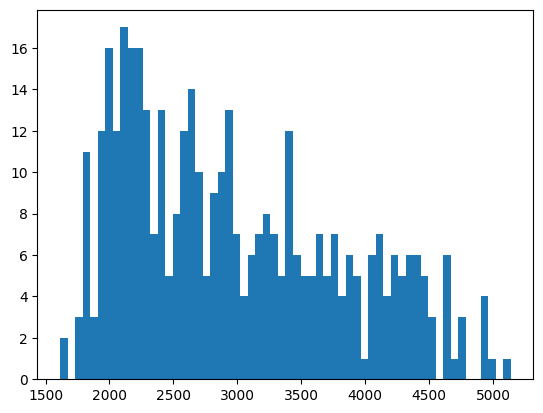

In [26]:
# Histograma
plt.hist(cars['weight'],bins = 60)

plt.show()

In [27]:
fig = px.box(cars, y = 'weight')
fig.show()

In [28]:
# Rango intercuartil
Q1_wght = cars['weight'].quantile(q=0.25)
Q3_wght = cars['weight'].quantile(q=0.75)

IQR_wght = Q3_wght - Q1_wght
print(IQR_wght," <- Rango Intercuartil ||| Mediana -> " ,cars['weight'].median())

1384.25  <- Rango Intercuartil ||| Mediana ->  2803.5


In [29]:
min_limit_wght = Q1_wght - 1.5 * IQR_wght # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_wght = Q3_wght + 1.5 * IQR_wght

print(min_limit_wght, max_limit_wght)

147.375 5684.375


##### Feature: **'acceleration'**

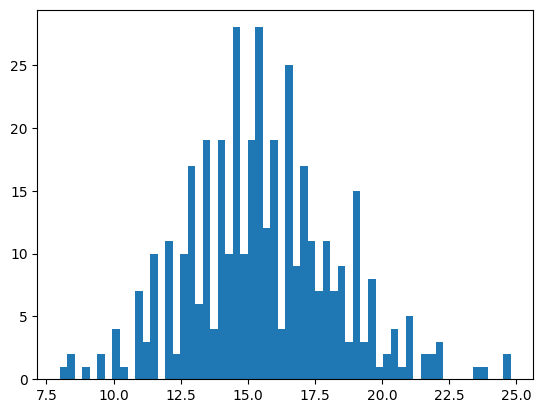

In [30]:
# Histograma
plt.hist(cars['acceleration'],bins = 60)

plt.show()

In [31]:
fig = px.box(cars, y = 'acceleration')
fig.show()

In [32]:
# Rango intercuartil
Q1_acce = cars['acceleration'].quantile(q=0.25)
Q3_acce= cars['acceleration'].quantile(q=0.75)

IQR_acce = Q3_acce - Q1_acce
print(round(IQR_acce,3)," <- Rango Intercuartil ||| Mediana -> " ,cars['acceleration'].median())

3.35  <- Rango Intercuartil ||| Mediana ->  15.5


In [33]:
min_limit_acce = Q1_acce - 1.5 * IQR_acce # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_acce = Q3_acce + 1.5 * IQR_acce

print(min_limit_acce, max_limit_acce)

8.8 22.2


mpg

##### Feature: **'weight'**

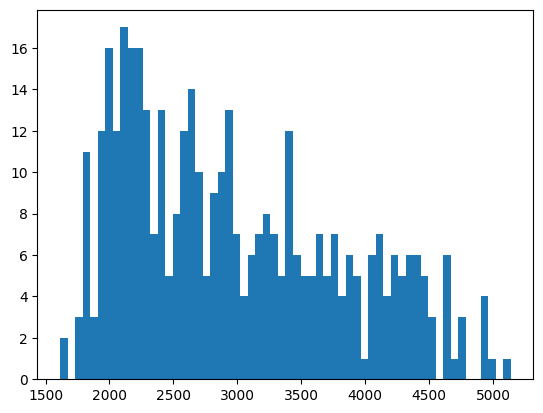

In [34]:
# Histograma
plt.hist(cars['weight'],bins = 60)

plt.show()

In [35]:
fig = px.box(cars, y = 'weight')
fig.show()

In [36]:
# Rango intercuartil
Q1_wght = cars['weight'].quantile(q=0.25)
Q3_wght = cars['weight'].quantile(q=0.75)

IQR_wght = Q3_wght - Q1_wght
print(IQR_wght," <- Rango Intercuartil ||| Mediana -> " ,cars['weight'].median())

1384.25  <- Rango Intercuartil ||| Mediana ->  2803.5


In [37]:
min_limit_wght = Q1_wght - 1.5 * IQR_wght # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_wght = Q3_wght + 1.5 * IQR_wght

print(min_limit_wght, max_limit_wght)

147.375 5684.375


##### Feature: **'mpg'**

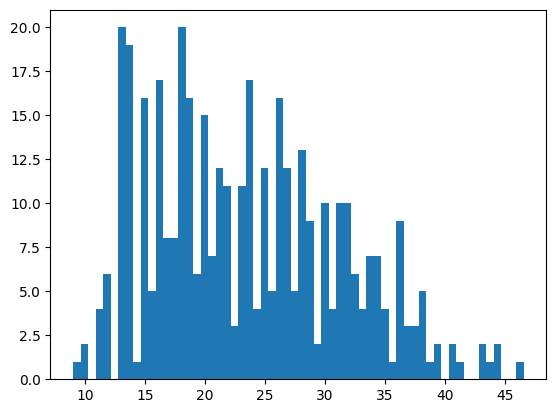

In [38]:
# Histograma
plt.hist(cars['mpg'],bins = 60)

plt.show()

In [39]:
fig = px.box(cars, y = 'mpg')
fig.show()

In [40]:
# Rango intercuartil
Q1_mpg = cars['mpg'].quantile(q=0.25)
Q3_mpg= cars['mpg'].quantile(q=0.75)

IQR_mpg = Q3_mpg - Q1_mpg
print(IQR_mpg," <- Rango Intercuartil ||| Mediana -> " ,cars['mpg'].median())

11.5  <- Rango Intercuartil ||| Mediana ->  23.0


In [41]:
min_limit_mpg = Q1_mpg - 1.5 * IQR_mpg # nos da un valor negativo pq estamos tratando de hallar el limite minimo en una distribucion no simetrica
max_limit_mpg = Q3_mpg + 1.5 * IQR_mpg

print(min_limit_mpg, max_limit_mpg)

0.25 46.25


#### Variables Cualitativas

##### Feature: **'cylinders'**
Variable cualitativa

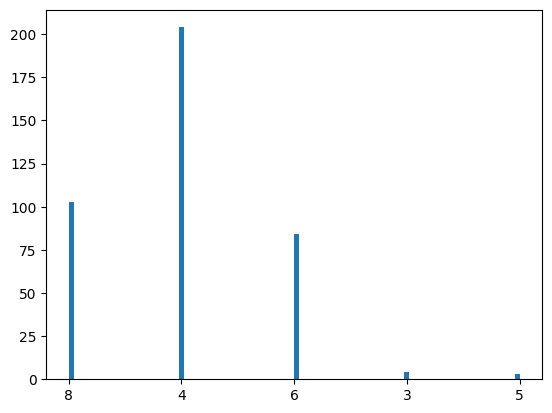

In [42]:
# Histograma
plt.hist(cars['cylinders'],bins = 90)

plt.show()

##### Feature: **'origin'**
Variable cualitativa

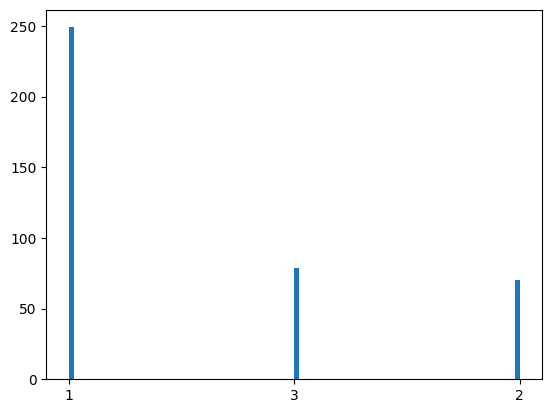

In [43]:
# Histograma
plt.hist(cars['origin'],bins = 90)

plt.show()

##### Feature: **'model year'**
Variable cualitativa

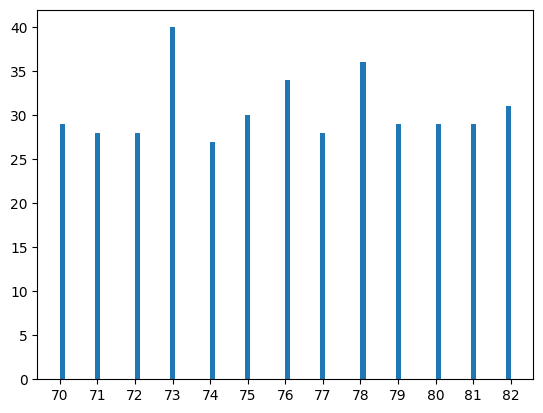

In [44]:
# Histograma
plt.hist(cars['model year'],bins = 90)

plt.show()

## Análisis Multivariables
Enfocada solo en variables numericas (no considera las variables cualitativas).

In [47]:
cars.describe()

,displacement,horsepower,weight,acceleration,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,193.425879,104.469388,2970.424623,15.568090,23.514573
std,104.269838,38.199187,846.841774,2.757689,7.815984
min,68.000000,46.000000,1613.000000,8.000000,9.000000
25%,104.250000,76.000000,2223.750000,13.825000,17.500000
50%,148.500000,95.000000,2803.500000,15.500000,23.000000
75%,262.000000,125.000000,3608.000000,17.175000,29.000000
max,455.000000,230.000000,5140.000000,24.800000,46.600000


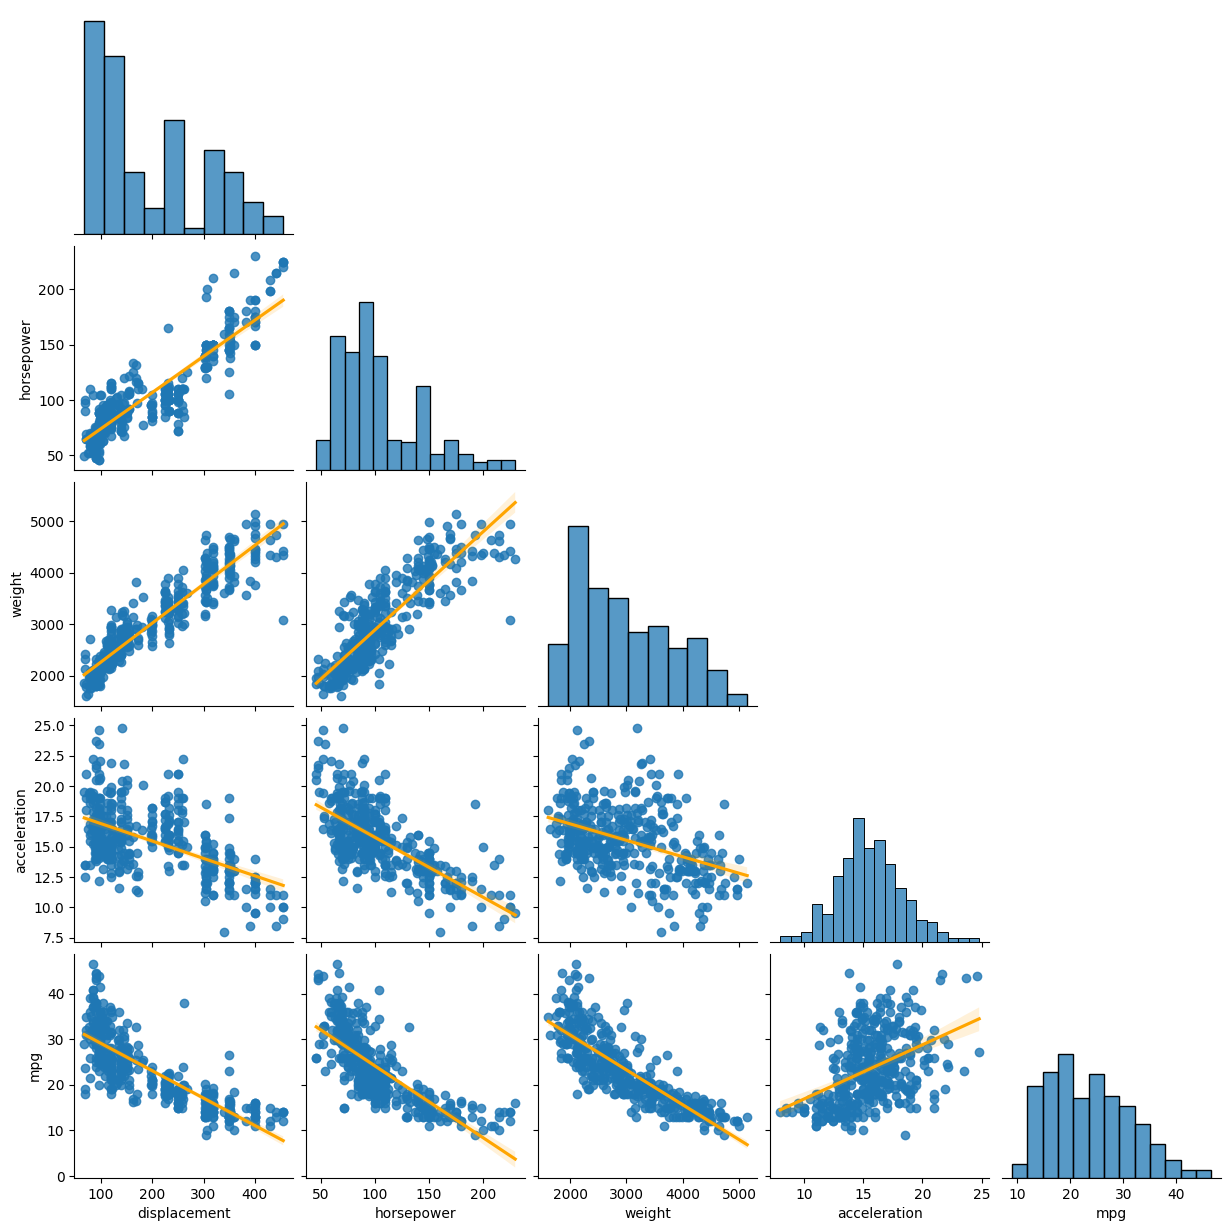

In [45]:
sns.pairplot(cars, corner = True, kind="reg" , plot_kws={'line_kws':{'color':'orange'}})
plt.show()

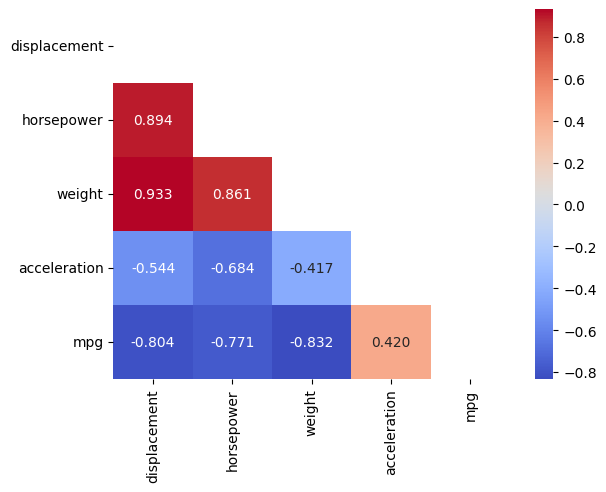

In [46]:
import warnings
warnings.filterwarnings('ignore')

corr = cars.corr()
matrix = np.triu(corr)
ax = sns.heatmap(cars.corr(),cmap='coolwarm', fmt=".3f", annot=True, mask=matrix)

¿Es un problema lineal?

**R.-** Según el estudio de las variables, es un problema lineal ya que 3 variables se coportan de forma a una correlación lineal negativa [**'displacement' , 'horsepower' , 'weight'**] y una de forma de correlación lineal positiva [**'acceleration'**] referente a la variable dependiente **['mpg']**.



## Modelos de Regresión Multilineal

### Creación de set de testeo para comprobar el rendimiento del modelo estadístico.

In [48]:
cars_test = cars
y_true = cars_test['mpg']
X_test = cars_test.drop(columns=['cylinders','model year','origin','car name','mpg'])

In [ ]:
y_true.head(5)

In [ ]:
X_test.head(5)

In [107]:
cars_test2 = cars
cars_test2 = cars_test2.drop(columns=['cylinders','model year','origin','car name'])

In [ ]:
cars_test2.head(5)

### Modelo de regresión multilineal **N°1**
Considera todas las variables numericas, que se mencionarán a continuación:
```
cars['displacement']
cars['horsepower']
cars['weight']
cars['acceleration']
```

In [75]:
lm1 = sfm.ols(formula= "mpg ~ displacement + horsepower + weight + acceleration" , data = cars ).fit()

In [85]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     234.3
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          1.26e-102
Time:                        01:16:20   Log-Likelihood:                -1140.0
No. Observations:                 398   AIC:                             2290.
Df Residuals:                     393   BIC:                             2310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       44.9503      2.418     18.589      0.000      40.196      49.704
displacement    -0.0068      0.007     -1.012      0.312      -0.020       0.006
horsepower      -0.0376      0.016     -2.346      0.019      -0.069      -0.006
weight          -0.0054      0.001     -6.787      0.000      -0.007      -0.004
acceleration    -0.0022      0.123     -0.018      0.986      -0.243       0.239
==============================================================================
Omnibus:                       38.209   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.354
Skew:                           0.713   Prob(JB):                     1.16e-11
Kurtosis:                       4.000   Cond. No.                     3.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
y_pred1 = lm1.predict(X_test)

print("Métricas")
print('MAE:', round(metrics.meanabs(y_true,y_pred1),5))
print('MSE:', round(metrics.mse(y_true,y_pred1),5))
print('RMSE:', round(metrics.rmse(y_true,y_pred1),5))
print()
print("Coeficiente de determinación")
print('R2:', lm1.rsquared)
print('R2-adj:', lm1.rsquared_adj)

Métricas
MAE: 3.25015
MSE: 18.00461
RMSE: 4.24318

Coeficiente de determinación
R2: 0.7045330829951926
R2-adj: 0.7015257861300037


### Modelo de regresión multilineal **N°2**
Considera todas las variables numericas, que se mencionarán a continuación:
```
cars['displacement']
cars['horsepower']
cars['weight']
```

In [79]:
lm2 = sfm.ols(formula= "mpg ~ displacement + horsepower + weight" , data = cars ).fit()

In [80]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     313.2
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          6.53e-104
Time:                        01:14:57   Log-Likelihood:                -1140.0
No. Observations:                 398   AIC:                             2288.
Df Residuals:                     394   BIC:                             2304.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       44.9132      1.198     37.492      0.000      42.558      47.268
displacement    -0.0068      0.007     -1.031      0.303      -0.020       0.006
horsepower      -0.0374      0.013     -2.957      0.003      -0.062      -0.013
weight          -0.0054      0.001     -7.657      0.000      -0.007      -0.004
==============================================================================
Omnibus:                       38.132   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.215
Skew:                           0.713   Prob(JB):                     1.25e-11
Kurtosis:                       3.998   Cond. No.                     1.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
y_pred2 = lm2.predict(X_test)

print("Métricas")
print('MAE:', round(metrics.meanabs(y_true,y_pred2),5))
print('MSE:', round(metrics.mse(y_true,y_pred2),5))
print('RMSE:', round(metrics.rmse(y_true,y_pred2),5))
print()
print("Coeficiente de determinación")
print('R2:', lm2.rsquared)
print('R2-adj:', lm2.rsquared_adj)

Métricas
MAE: 3.25029
MSE: 18.00462
RMSE: 4.24319

Coeficiente de determinación
R2: 0.7045328486453861
R2-adj: 0.7022830987619754


### Modelo de regresión multilineal **N°3**
Considera todas las variables numericas, que se mencionarán a continuación:
```
cars['horsepower']
cars['weight']
```

In [82]:
lm3 = sfm.ols(formula= "mpg ~  horsepower + weight" , data = cars ).fit()

In [83]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     469.1
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          4.53e-105
Time:                        01:15:09   Log-Likelihood:                -1140.5
No. Observations:                 398   AIC:                             2287.
Df Residuals:                     395   BIC:                             2299.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.8415      0.790     58.047      0.000      44.289      47.394
horsepower    -0.0439      0.011     -3.990      0.000      -0.066      -0.022
weight        -0.0060      0.000    -12.034      0.000      -0.007      -0.005
==============================================================================
Omnibus:                       35.593   Durbin-Watson:                   0.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.770
Skew:                           0.687   Prob(JB):                     1.15e-10
Kurtosis:                       3.935   Cond. No.                     1.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
y_pred3 = lm3.predict(X_test)

print("Métricas")
print('MAE:', round(metrics.meanabs(y_true,y_pred3),5))
print('MSE:', round(metrics.mse(y_true,y_pred3),5))
print('RMSE:', round(metrics.rmse(y_true,y_pred3),5))
print()
print("Coeficiente de determinación")
print('R2:', lm3.rsquared)
print('R2-adj:', lm3.rsquared_adj)

Métricas
MAE: 3.25479
MSE: 18.05315
RMSE: 4.2489

Coeficiente de determinación
R2: 0.7037364869594709
R2-adj: 0.7022364185390125


¿Que modelo se eligió, según el estudio ?

**R.-** El modelo elegido sera el, modelo 2:
```
mpg ~ displacement + horsepower + weight
```




## Estudios de supuestos, en base del modelo eligido que es el 2

### **Suposición #1**: Existe una relación lineal entre las variables predictoras y la variable de respuesta.

eval_env: 1


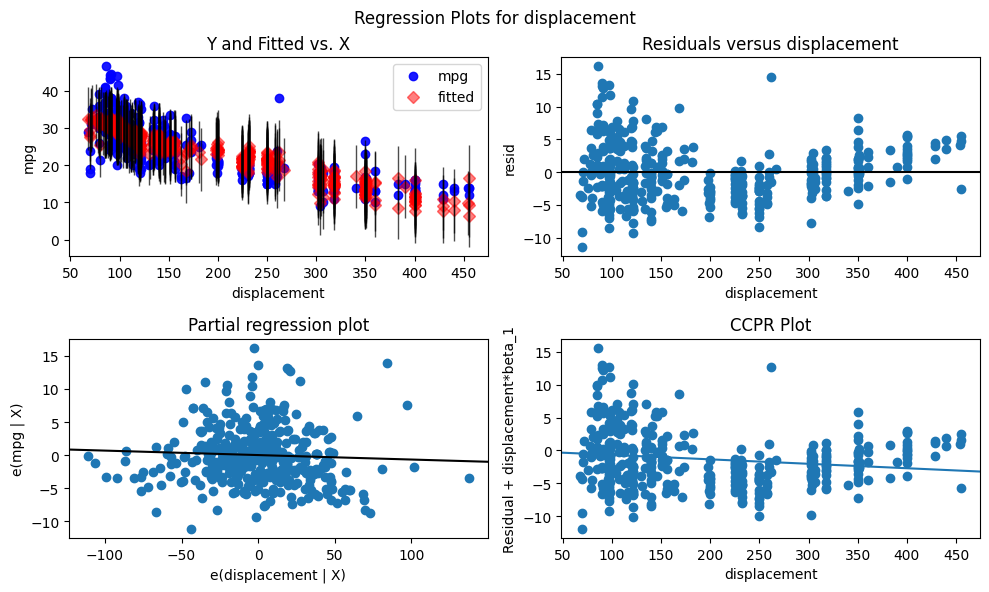

In [90]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

#define figure size
fig = plt.figure(figsize=(10,6))

#produce regression plots
fig = sm.graphics.plot_regress_exog(lm2, 'displacement', fig=fig)

eval_env: 1


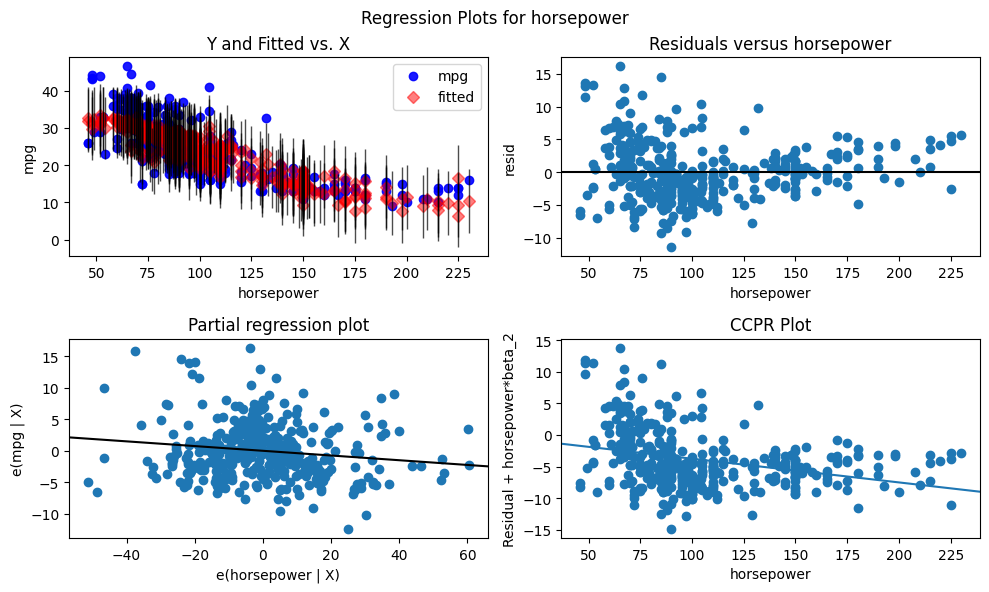

In [95]:
#define figure size
fig = plt.figure(figsize=(10,6))

#produce regression plots
fig = sm.graphics.plot_regress_exog(lm2, 'horsepower', fig=fig)

eval_env: 1


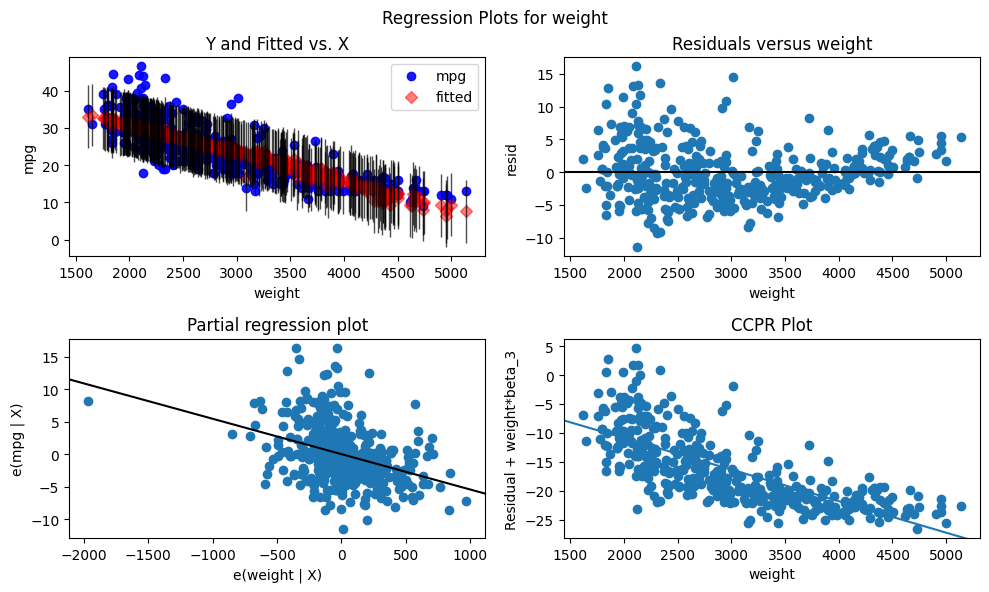

In [94]:
#define figure size
fig = plt.figure(figsize=(10,6))

#produce regression plots
fig = sm.graphics.plot_regress_exog(lm2, 'weight', fig=fig)

En los tres gráficos, los residuos parecen estar dispersos aleatoriamente alrededor de cero, lo que indica que la heterocedasticidad no es un problema con ninguna de las variables predictoras del modelo.

### **Suposición #2**: Independencia de los residuos (**Durbin-Watson Test**).

In [93]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
durbin_watson(lm2.resid)

0.8415344241146278

El estadístico de prueba es **0.842** Dado que esto está dentro del rango de **1.5 y 2.5**, consideraríamos que la autocorrelación no es problemática en este modelo de regresión.


### **Suposición #3**: Homocedasticidad de los residuos (**Breusch-Pagan Test**).

In [96]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(lm2.resid, lm2.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 28.397769109114282),
 ('p-value', 2.996689529386869e-06),
 ('f-value', 10.090776961331136),
 ('f p-value', 2.030449781899129e-06)]

El estadístico del multiplicador de Lagrange para la prueba es **28.398** y el p-value correspondiente es **2.996e-06**. Debido a que este p-value es menor que 0.05, se rechaza la hipótesis nula y se acepta la hipótesis alternativa, por lo cual la homocedasticidad no está presente en el modelo.

### **Supuesto #4**: Normalidad de los residuos (**Shapiro-Wilk test**).

In [112]:
from scipy.stats import shapiro

# conduct the  Shapiro-Wilk Test
shapiro(cars_test2)

ShapiroResult(statistic=0.5812125205993652, pvalue=0.0)

El p-value es **0.0**, que es menor que el umbral (0.05), que es el alfa (0.05), entonces podemos rechazar la hipótesis nula, es decir, tenemos suficiente evidencia para decir que la muestra no proviene de una distribución normal.

### **Suposición #5**: Verificación que no exista multicolinealidad entre las variables predictoras.

* Un valor de 1 indica que no hay correlación entre una variable explicativa dada y cualquier otra variable explicativa en el modelo.

* Un valor entre 1 y 5 indica una correlación moderada entre una variable explicativa dada y otras variables explicativas en el modelo, pero esto a menudo no es lo suficientemente grave como para requerir atención.

* Un valor superior a 5 indica una correlación potencialmente severa entre una variable explicativa dada y otras variables explicativas en el modelo.

In [118]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable
y, X = dmatrices("mpg ~ displacement + horsepower + weight", data= cars_test2, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [119]:
#Nota: Se Ignora el VIF para la "Intersección" en el modelo ya que este valor es irrelevante.

vif[1:4]

,VIF,variable
1,10.204101,displacement
2,5.107289,horsepower
3,7.922033,weight


Como son valores **VIF > 5**, se indica una correlación potencialmente severa entre una variable explicativa dada y otras variables explicativas en el modelo, por lo cual existe multicolinialidad entre variables.

**¿Cuál es el factor que mayor incidencia tiene el rendimineto? ¿Por que?**

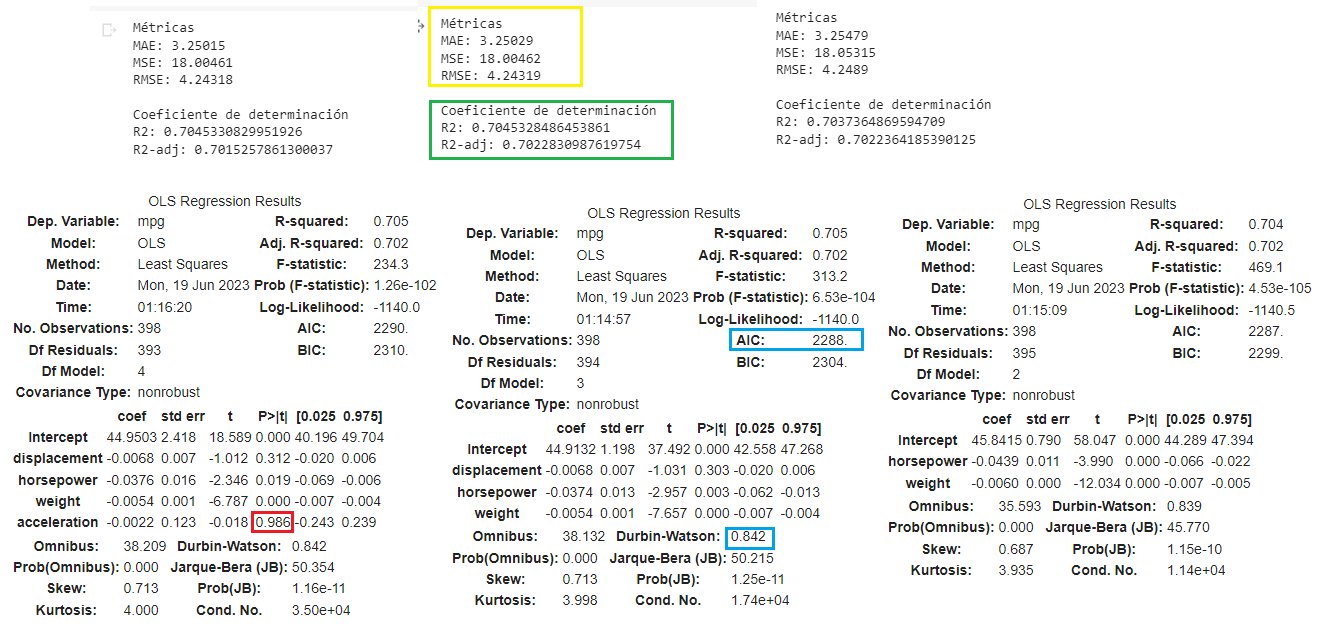



**R.-** _Se eligió el modelo 2 porque posee mejores metricas de rendimiento en comparación a los otros modelos, incluyendo el hecho que posee una variable no significante que se deberia descartar que es **'displacement'**, la cual no mejora las métricas si se descartara la variable para ser el modelo 3, se podria afirmar que las tres variables **'displacement'**, **'horsepower'** y **'weight'** como poseen una correlación lineal negativa se encargan de entregar información al modelo para predecir la variable **'mpg'**._

**¿Es un mejor modelo que el simple? ¿Cómo se evidencia aquello?**

**R.-** _Se podria decir que si, porque se agregan más información y se da el caso de contar con más de una variable predictora, podríamos pensar en que una opción sería ajustar un modelo de regresión a cada uno por separado. Sin embargo, este enfoque puede no llegar a resultar del todo satisfactorio, ya que cada ecuación de regresión estaría ignorando las demás a la hora de estimar los coeficientes de regresión. Además, si se diera que los predictores estuvieran correlacionados entre sí ello podría llevar a estimaciones erróneos haciendo el ajuste por separado._

_Por lo cual una ventaja de la regresión lineal múltiple es que evalúa el efecto de cada predictor en presencia del resto, evitando el fenómeno de confusión que puede aparecer cuando la asociación observada entre un predictor y la variable respuesta se explica por otra variable (factor de confusión) de manera total o parcial._